In [13]:
# load packages
using PotentialLearning
using LinearAlgebra, Random, Statistics, StatsBase, Distributions
using Determinantal
using DataFrames
using Zarr
using CairoMakie

In [14]:
## load functions
include("./utils/utils.jl")

## load dataset
elname = "Hf" # element name
include("./experiments/01_load_data.jl")

loading configurations and energies


loading descriptors


DONE


In [18]:
## compute kernel matrices

# dot product - primal kernel
k1 = DotProduct()
K1, L1 = compute_ell_ensemble(desc, k1)

# dot product - dual kernel
desc_t = [desc_mat[:,i] for i = 1:ndesc]
Kt, Lt = compute_ell_ensemble(desc_t, k1)

# RBF - primal kernel
Cd = Symmetric(cov(desc))
precisionmat = Symmetric(pinv(Cd, 1e-6))
d = Euclidean(precisionmat)
k2 = RBF(d, ℓ=1.0)
K2, L2 = compute_ell_ensemble(desc, k2)

([1.0 0.950740682611655 … 3.6891020672225297e-7 3.7344070906522383e-7; 0.950740682611655 1.0 … 3.852168946698663e-7 3.89506597267225e-7; … ; 3.6891020672225297e-7 3.852168946698663e-7 … 1.0 0.9999853965866592; 3.7344070906522383e-7 3.89506597267225e-7 … 0.9999853965866592 1.0], L-Ensemble.
Number of items in ground set : 1614. Max. rank : 1614. Rescaling constant α=1.0
)

Comparing kernel matrices

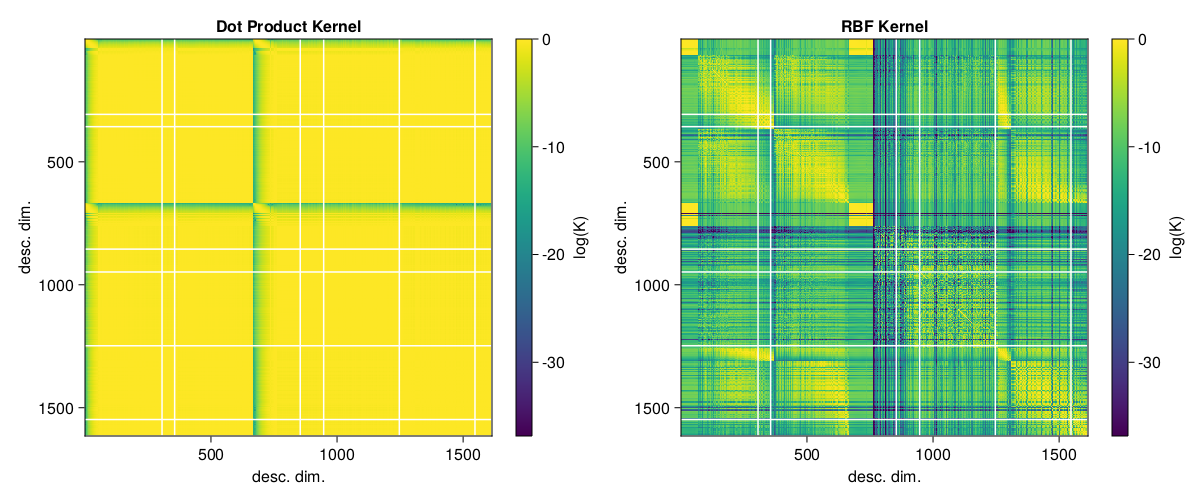

In [23]:
## plot kernel matrices
fig = Figure(resolution = (1200, 500))
ax1 = Axis(fig[1,1][1,1],
    title="Dot Product Kernel",
    xlabel="desc. dim.",
    ylabel="desc. dim.",
    yticks=(Vector(1:500:1500) .+ (nconf-1500), [string(x) for x in 1500:-500:1]),
)
hm1 = heatmap!(ax1, 1:nconf, 1:nconf, log.(K1[end:-1:1,:]), colorrange=(log(1e-16), log(1)))
Colorbar(fig[1,1][1,2], hm1, label="log(K)")
[vlines!(ax1, x, color=:white) for x in cumsum(n_per_ds)]
[hlines!(ax1, nconf - x, color=:white) for x in cumsum(n_per_ds)]

ax2 = Axis(fig[1,2][1,1],
    title="RBF Kernel",
    xlabel="desc. dim.",
    ylabel="desc. dim.",
    yticks=(Vector(1:500:1500) .+ (nconf-1500), [string(x) for x in 1500:-500:1]),
)
hm2 = heatmap!(ax2, 1:nconf, 1:nconf, log.(K2[end:-1:1,:]), colorrange=(log(1e-16), log(1)))
Colorbar(fig[1,2][1,2], hm2, label="log(K)")
[vlines!(ax2, x, color=:white) for x in cumsum(n_per_ds)]
[hlines!(ax2, nconf - x, color=:white) for x in cumsum(n_per_ds)]
fig


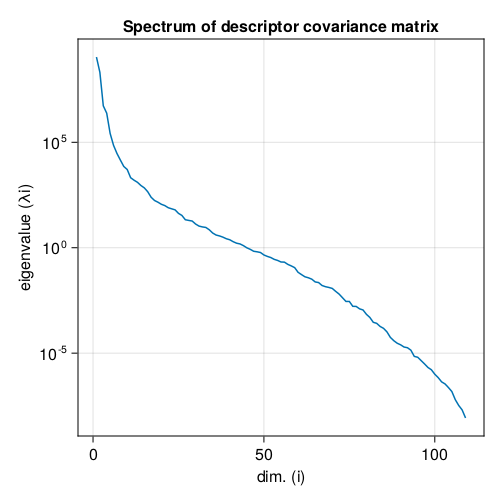

In [26]:
## plot eigenspectrum of descriptor covariance
λd = eigvals(Cd)[end:-1:1]

fig = Figure(resolution = (500, 500))
ax = Axis(fig[1,1],
    title="Spectrum of descriptor covariance matrix",
    xlabel="dim. (i)",
    ylabel="eigenvalue (λi)",
    yscale=log10,
)
lines!(ax, 1:ndesc, λd[findall(x -> x > 0, λd)])
fig

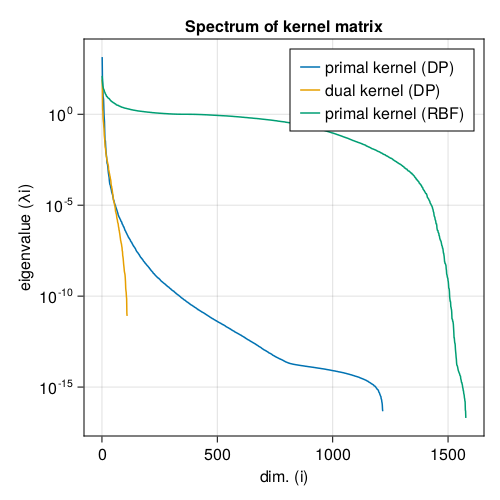

In [27]:
## plot eigenspectrum of kernel matrices
λ1 = eigvals(K1)[end:-1:1]; W1 = eigvecs(K1)
λt = eigvals(Kt)[end:-1:1]; Wt = eigvecs(Kt)
λ2 = eigvals(K2)[end:-1:1]; W2 = eigvecs(K2)

fig = Figure(resolution = (500, 500))
ax = Axis(fig[1,1],
    title="Spectrum of kernel matrix",
    xlabel="dim. (i)",
    ylabel="eigenvalue (λi)",
    yscale=log10,
)
lines!(ax, 1:length(findall(x -> x > 0, λ1)), λ1[findall(x -> x > 0, λ1)], label="primal kernel (DP)")
lines!(ax, 1:length(findall(x -> x > 0, λt)), λt[findall(x -> x > 0, λt)], label="dual kernel (DP)")
lines!(ax, 1:length(findall(x -> x > 0, λ2)), λ2[findall(x -> x > 0, λ2)], label="primal kernel (RBF)")
axislegend(ax)
fig

Evaluating sample selection by DPPs

In [32]:
niter = 100 # number of sampling iterations
batch_sizes = [20, 40, 80, 160, 320, 640] # k number of samples by k-DPP

6-element Vector{Int64}:
  20
  40
  80
 160
 320
 640

In [33]:
## initialize arrays for storing data
ip1 = Dict{Int64, Vector{Float64}}()
ip2 = Dict{Int64, Vector{Float64}}()
conf_ct1 = Dict{Int64, Vector{Int64}}(
    bs => zeros(nconf) for bs in batch_sizes
)
conf_ct2 = Dict{Int64, Vector{Int64}}(
    bs => zeros(nconf) for bs in batch_sizes
)
ds_ct1 = Dict{Int64, Dict}(
    bs => Dict{Int64, Vector{Int64}}(
        n => zeros(niter) for n = 1:nds
    ) for bs in batch_sizes
)
ds_ct2 = Dict{Int64, Dict}(
    bs => Dict{Int64, Vector{Int64}}(
        n => zeros(niter) for n = 1:nds
    ) for bs in batch_sizes
)

Dict{Int64, Dict} with 6 entries:
  320 => Dict(5=>[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
  20  => Dict(5=>[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
  640 => Dict(5=>[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
  80  => Dict(5=>[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
  40  => Dict(5=>[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
  160 => Dict(5=>[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0…

In [34]:
## sample k-DPP
for bs in batch_sizes
    println("===== starting batch $bs =====")
    # compute inclusion probabilities
    ip1[bs] = get_inclusion_prob(L1, bs)
    ip2[bs] = get_inclusion_prob(L2, bs)

    # compute dataset selection
    for iter = 1:niter
        # println("iter $iter")
        id1 = get_random_subset(L1, bs)
        id2 = get_random_subset(L2, bs)
        ds_rep1 = ds_ids[id1]
        ds_rep2 = ds_ids[id2]

        # count by configuration
        conf_ct1[bs][id1] = conf_ct1[bs][id1] .+ 1
        conf_ct2[bs][id2] = conf_ct2[bs][id2] .+ 1

        # count by dataset
        for n = 1:nds
            ds_ct1[bs][n][iter] = Int(length(findall(x -> x == n, ds_rep1)))
            ds_ct2[bs][n][iter] = Int(length(findall(x -> x == n, ds_rep2)))
        end
    end
end

===== starting batch 20 =====


===== starting batch 40 =====


===== starting batch 80 =====


===== starting batch 160 =====


===== starting batch 320 =====


===== starting batch 640 =====


In [35]:
## plot inclusion probabilities
figs = Vector{Figure}(undef, length(batch_sizes))
inds = reduce(vcat, [1, cumsum(n_per_ds)])

for (n,bs) in enumerate(batch_sizes)
    figs[n] = Figure(resolution = (1000, 500))
    ax1 = Axis(figs[n][1,1],
        title="k-DPP inclusion prob. (k=$bs, dot product kernel)",
        xlabel="inclusion probability",
        ylabel="empirical probability",
    )
    ax2 = Axis(figs[n][1,2],
        title="k-DPP inclusion prob. (k=$bs, RBF kernel)",
        xlabel="inclusion probability",
        ylabel="empirical probability",
    )

    [scatter!(ax1,
        ip1[bs][inds[j]:inds[j+1]],
        conf_ct1[bs][inds[j]:inds[j+1]] ./ niter,
        label="DS$j")
        for j = 1:nds
    ]
    lrng = LinRange( 
            minimum([minimum(ip1[bs]),
            minimum(conf_ct1[bs] ./ niter)]),
            maximum([maximum(ip1[bs]),
            maximum(conf_ct1[bs] ./ niter)]),
            100)
    lines!(ax1, lrng, lrng, color=:red)
    axislegend(ax1, position=:rb)
    
    [scatter!(ax2,
        ip2[bs][inds[j]:inds[j+1]],
        conf_ct2[bs][inds[j]:inds[j+1]] ./ niter,
        label="DS$j")
        for j = 1:nds
    ]
    lrng = LinRange( 
        minimum([minimum(ip2[bs]),
        minimum(conf_ct2[bs] ./ niter)]),
        maximum([maximum(ip2[bs]),
        maximum(conf_ct2[bs] ./ niter)]),
        100)
    lines!(ax2, lrng, lrng, color=:red)
    axislegend(ax2, position=:rb)
end

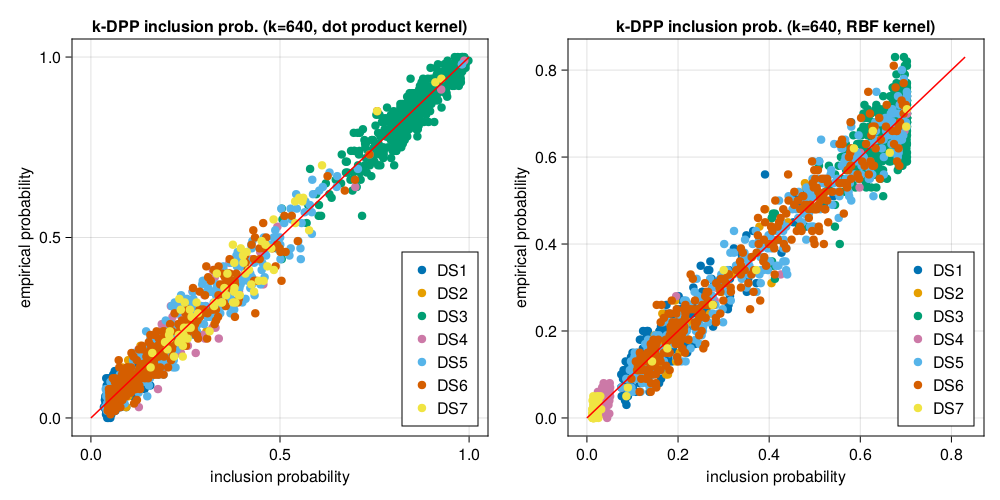

In [41]:
figs[6] # change number

In [42]:
## plot representation of each dataset
figs2 = Vector{Figure}(undef, length(batch_sizes))

for (n,bs) in enumerate(batch_sizes)
    figs2[n] = Figure(resolution = (1000, 500))
    ax = Axis(figs2[n][1,1],
        title="Dataset Selection in k-DPP (k=$bs)",
        xlabel="dataset",
        ylabel="proportion of selection",
        xticks=1:nds,
    )

    maxp = maximum([maximum(ds_ct1[bs][j] ./ bs ./ n_per_ds[j]) for j = 1:nds])
    srslvl = 1 / nconf
    binrng = LinRange(0, maxp, 50)

    hist!(ax, ds_ct1[bs][1] ./ bs ./ n_per_ds[1],
        scale_to=-0.75,
        offset=1,
        direction=:x,
        color=(:skyblue1, 0.5),
        bins=binrng,
        label="DP kernel")
    hist!(ax, ds_ct2[bs][1] ./ bs ./ n_per_ds[1],
        scale_to=-0.75,
        offset=1,
        direction=:x,
        color=(:magenta, 0.5),
        bins=binrng,
        label="RBF kernel")
    for j = 2:nds 
        hist!(ax, ds_ct1[bs][j] ./ bs ./ n_per_ds[j],
            scale_to=-0.75,
            offset=j, 
            direction=:x,
            color=(:skyblue1, 0.5),
            bins=binrng,
            )
        hist!(ax, ds_ct2[bs][j] ./ bs ./ n_per_ds[j],
            scale_to=-0.75,
            offset=j,
            direction=:x,
            color=(:magenta, 0.5),
            bins=binrng,
            )
    end
    hlines!(ax, srslvl, color=:red, label="SRS ref.")

    axislegend(ax)
end

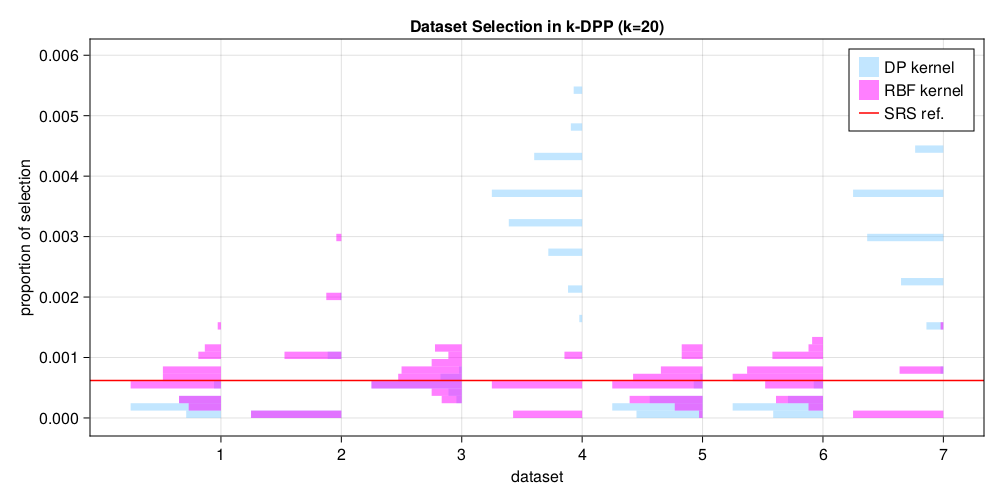

In [43]:
figs2[1] # change number